In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
HLA_alleles = data_tools.load_HLA_data()

<AxesSubplot:xlabel='zygosity', ylabel='Count'>

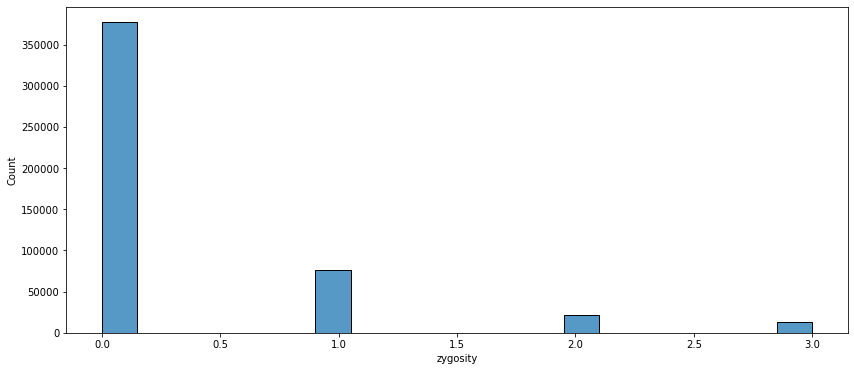

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(HLA_alleles["zygosity"], ax=ax)

# Add Grantham Distance

In [61]:
class_I_allele_map = gd.HLAAlleleSequenceMapping(gd.HLA_CLASS_I_ALLELE_AMINO_ACID_SEQUENCES_ABS_PATH)
grantham_distance = gd.GranthamDistance(gd.GRANTHAM_DISTANCE_MATRIX_PATH)

In [62]:
allele_columns = ["A1", "A2", "B1", "B2", "C1", "C2"]
if "grantham_divergence" not in HLA_alleles.columns:
    sequences = HLA_alleles[allele_columns].apply(class_I_allele_map._map, axis=1)
    distances = []
    for sequence in tqdm(sequences, unit=" sequence"):
        distances.append(grantham_distance.sequence_group_distance(sequence))

    HLA_alleles["grantham_divergence"] = distances
    
    save_path = constants.UK_BIOBANK_HLA_ALLELES_TSV_FULL_PATH
    HLA_alleles.to_csv(save_path, sep='\t', index=False)

In [63]:
data_tools.load_HLA_data(save_path)

,eid,A1,A2,B1,B2,C1,C2,zygosity,grantham_divergence
0,1000013,A*02:01,A*02:01,B*44:02,B*57:01,C*05:01,C*06:02,1,31.481250
1,1000024,A*01:01,A*01:01,B*07:02,B*08:01,C*07:01,C*07:02,1,32.060417
2,1000036,A*02:01,A*34:02,B*14:01,B*44:02,C*05:01,C*08:02,0,30.402083
3,1000048,A*02:01,A*68:01,B*07:02,B*51:01,C*01:02,C*07:02,0,34.847917
4,1000055,A*01:01,A*03:01,B*13:02,B*57:01,C*06:02,C*06:02,1,33.218750
...,...,...,...,...,...,...,...,...,...
488260,6025313,A*01:01,A*02:01,B*40:01,B*44:02,C*03:04,C*05:01,0,32.858333
488261,6025324,A*01:01,A*01:01,B*08:01,B*57:01,C*06:02,C*07:01,1,34.416667
488262,6025348,A*24:02,A*24:02,B*15:01,B*51:01,C*02:02,C*03:03,1,33.577083
488263,6025355,A*02:01,A*03:01,B*15:01,B*44:02,C*03:04,C*05:01,0,28.656250


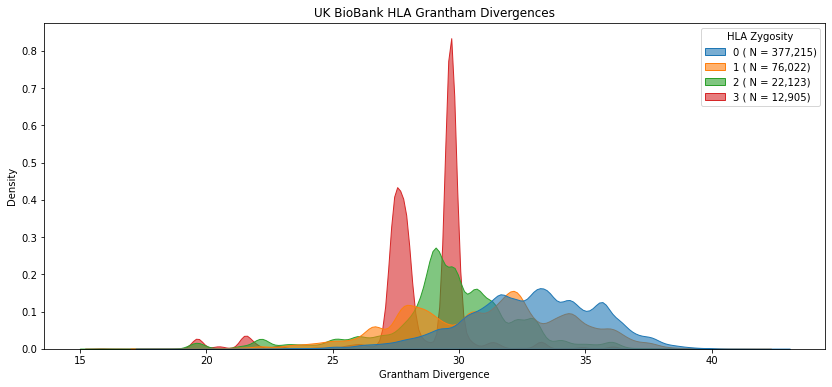

In [64]:
x, hue = "grantham_divergence", "zygosity"

fig, ax = plt.subplots(figsize=(14, 6))
sns_wrapper(sns.kdeplot, data=HLA_alleles, x=x, hue=hue, ax=ax, bw_method=.1, common_norm=False, shade=True)
add_plt_labels(ax, x=x)
ax.set_title("UK BioBank HLA Grantham Divergences")
ax.legend(title="HLA Zygosity")

fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("HLA_grantham_divergences.png"), facecolor="#fffffe")